In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

2024-04-26 01:01:45.894087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 01:01:45.895421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 01:01:46.058583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 01:01:46.458869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 01:01:49.677604: W tensorflow/compiler/tf2

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2024-04-26 01:01:56.609620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 01:01:58.171767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 01:01:58.172459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 01:01:58.192153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 01:01:58.192745: I external/local_xla/xla/stream_executor

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_1[0][0]']             
                                                                                            

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10


2024-04-26 01:02:23.439894: I external/local_xla/xla/service/service.cc:168] XLA service 0x44397a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 01:02:23.440001: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-04-26 01:02:23.560575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 01:02:24.863235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1714086145.261147  286970 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 26s 19ms/step - loss: 223.2525
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 138.2927
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 124.6324
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 119.2704
Epoch 5/10
469/469 [==============================] - 10s 20ms/step - loss: 116.0225
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 113.6920
Epoch 7/10
469/469 [==============================] - 7s 16ms/step - loss: 112.4508
Epoch 8/10
469/469 [==============================] - 9s 20ms/step - loss: 110.9541
Epoch 9/10
469/469 [==============================] - 14s 29ms/step - loss: 109.9928
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 109.1361


## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder(x_test)[2]

In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder(z_test_pred)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

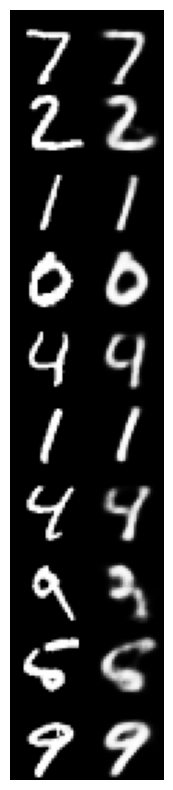

In [15]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2)

In [19]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred)

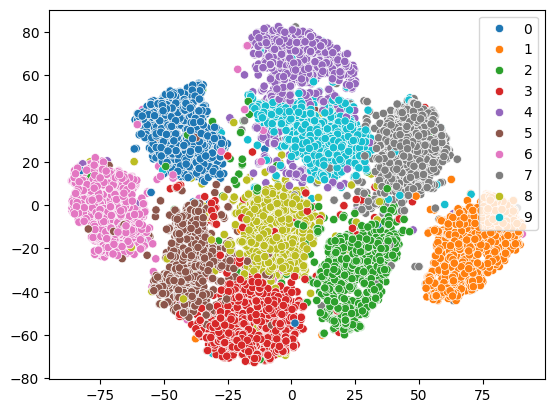

In [20]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [21]:
z_test_pred = vae.encoder(x_test)

In [22]:
i = 0
test = np.random.multivariate_normal(z_test_pred[0][i], np.diag(np.exp(z_test_pred[1][i])), size=(30))
test_pred = vae.decoder(test)

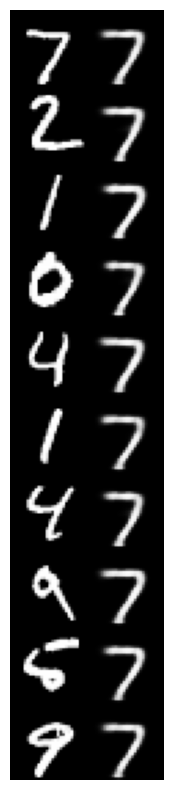

In [23]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# Task 2

In [24]:
latent_dim = 10
embed_dim = 10 # in practice latent_dim = latent_dim + embed_dim
encoder_inputs = keras.Input(shape=(original_dim,))
class_inputs = keras.Input(shape=(embed_dim, ))
x = keras.layers.Concatenate()([encoder_inputs, class_inputs])
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs, class_inputs], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 794)                  0         ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 256)                  203520    ['concatenate[0][0]']   

In [25]:
latent_inputs = keras.Input(shape=(latent_dim,))
class_inputs = keras.Input(shape=(embed_dim,))
x = keras.layers.Concatenate()([latent_inputs, class_inputs])
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model([latent_inputs, class_inputs], decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 20)                   0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 256)                  5376      ['concatenate_1[0][0]'] 

In [29]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.emb = tf.keras.layers.Embedding(10, embed_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        x, y = data[0]
        with tf.GradientTape() as tape:
            y = self.emb(y)
            z_mean, z_log_var, z = self.encoder((x, y))
            reconstruction = self.decoder((z, y))

            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [30]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit((x_train, y_train), epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 13s 18ms/step - loss: 222.5269
Epoch 2/10
469/469 [==============================] - 8s 16ms/step - loss: 136.8467
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 123.3497
Epoch 4/10
469/469 [==============================] - 13s 27ms/step - loss: 117.0866
Epoch 5/10
469/469 [==============================] - 12s 25ms/step - loss: 113.5064
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 110.5783
Epoch 7/10
469/469 [==============================] - 8s 18ms/step - loss: 108.7048
Epoch 8/10
469/469 [==============================] - 7s 14ms/step - loss: 107.0529
Epoch 9/10
469/469 [==============================] - 6s 13ms/step - loss: 105.7770
Epoch 10/10
469/469 [==============================] - 10s 22ms/step - loss: 104.3255


## f)

In [32]:
z_test_pred = vae.encoder((x_test, vae.emb(y_test)))[2]

In [33]:
test_pred = vae.decoder((z_test_pred, vae.emb(y_test)))

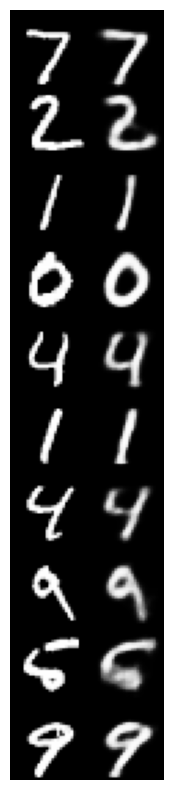

In [34]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## g)

In [35]:
tsne = TSNE(n_components=2)
z_test_pred = np.concatenate((z_test_pred, vae.emb(y_test)), axis=-1)
z_test_pred_tsne = tsne.fit_transform(z_test_pred)

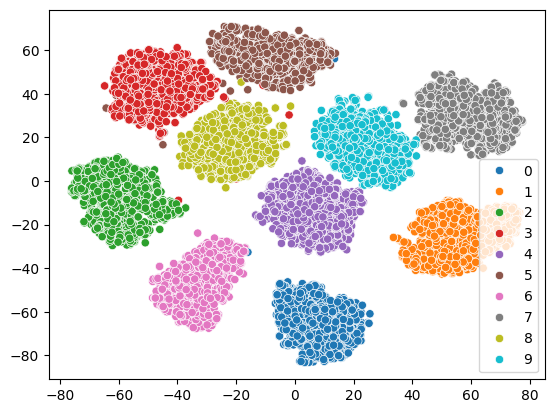

In [36]:
# Much better separation than in Task 1
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [45]:
z_test_pred = vae.encoder((x_test, vae.emb(y_test)))

In [54]:
i = 0
test = np.random.multivariate_normal(z_test_pred[0][i], np.diag(np.exp(z_test_pred[1][i])), size=(30))
test_pred = vae.decoder((test, vae.emb(np.array([7] * 30))))

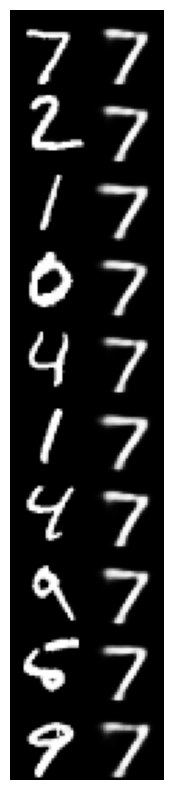

In [57]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()